In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

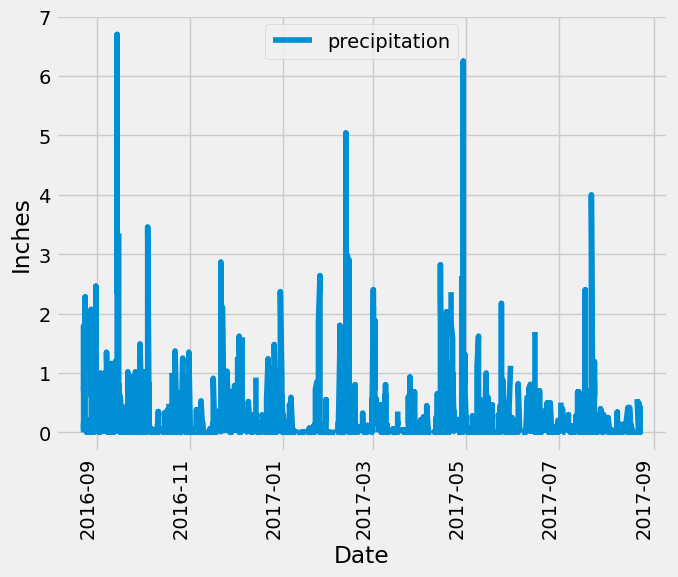

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date_str = most_recent_date[0]

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date_str, "%Y-%m-%d") - dt.timedelta(days=365)
one_year_ago = one_year_ago.date()

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(results, columns=["date", "precipitation"])

# Sort the dataframe by date
precipitation_df["date"] = pd.to_datetime(precipitation_df["date"])
precipitation_df.set_index("date", inplace=True)
precipitation_df = precipitation_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(y="precipitation", use_index=True, figsize=(7, 6))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(loc="upper center")
plt.xticks(rotation=90)
plt.tight_layout()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
low_high_avg_temp = session.query(func.min(Measurement.tobs),
                    func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active_stations[0][0]).all()
low_high_avg_temp

[(54.0, 85.0, 71.66378066378067)]

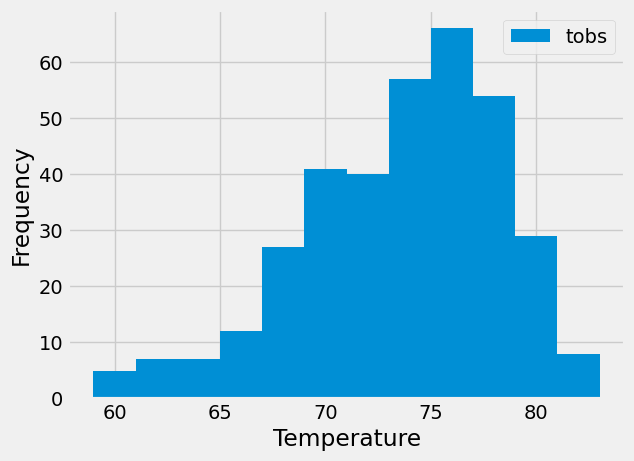

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temp_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_stations[0][0]).\
    filter(Measurement.date >= one_year_ago - dt.timedelta(days=1)).all()

#Creating a dataframe from the temperature list 
temperature_df = pd.DataFrame(last_year_temp_data, columns=["temperature"])

# Plot the histogram
plt.figure()
plt.hist(temperature_df["temperature"], bins=12, label="tobs")

# Set labels
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()

# Show the plot
plt.show()

# Close Session

In [16]:
# Close Session
session.close()